### AdaBoost Regressor - from scratch... pseudocode walkthrough

In [924]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [925]:
from sklearn.datasets import load_diabetes
lbr = load_diabetes()
df = pd.DataFrame(lbr.data, columns=lbr.feature_names)
df['y'] = lbr.target
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [926]:
df.shape

(442, 11)

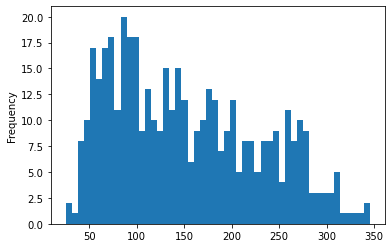

In [927]:
df['y'].plot.hist(bins=50)
plt.show()

In [928]:
#print(lbr.DESCR)

In [929]:
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
0,0.045341,-0.044642,-0.006206,-0.015999,0.125019,0.125198,0.019187,0.034309,0.032432,-0.005220,219.0
1,0.092564,-0.044642,0.036907,0.021872,-0.024960,-0.016658,0.000779,-0.039493,-0.022517,-0.021788,70.0
2,0.063504,0.050680,-0.004050,-0.012556,0.103003,0.048790,0.056003,-0.002592,0.084492,-0.017646,202.0
3,0.096197,-0.044642,0.051996,0.079265,0.054845,0.036577,-0.076536,0.141322,0.098648,0.061054,230.0
4,0.012648,0.050680,-0.020218,-0.002228,0.038334,0.053174,-0.006584,0.034309,-0.005142,-0.009362,111.0


In [930]:
cols = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

### Step-1

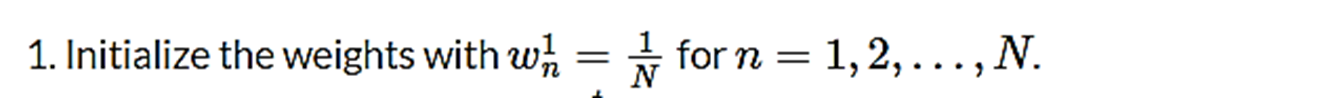

In [931]:
m=442
w1 = 1/m
df['w1'] = w1

In [932]:
df.iloc[:,8:].head(4)

,s5,s6,y,w1
0,0.032432,-0.005220,219.0,0.002262
1,-0.022517,-0.021788,70.0,0.002262
2,0.084492,-0.017646,202.0,0.002262
3,0.098648,0.061054,230.0,0.002262


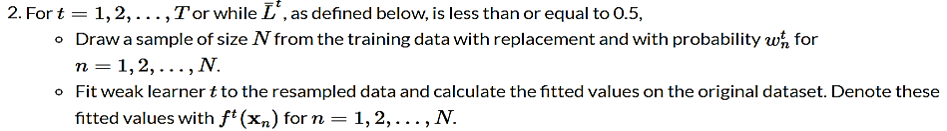

In [933]:
dtr = DecisionTreeRegressor(random_state=42, max_depth=1)
dfs = df.sample(n = m, replace = True, random_state=42)

dtr.fit(dfs.loc[:,cols], dfs['y'])

DecisionTreeRegressor(max_depth=1, random_state=42)

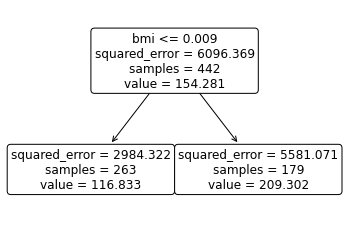

In [934]:
tree.plot_tree(dtr, rounded=True, feature_names=cols)
plt.show()

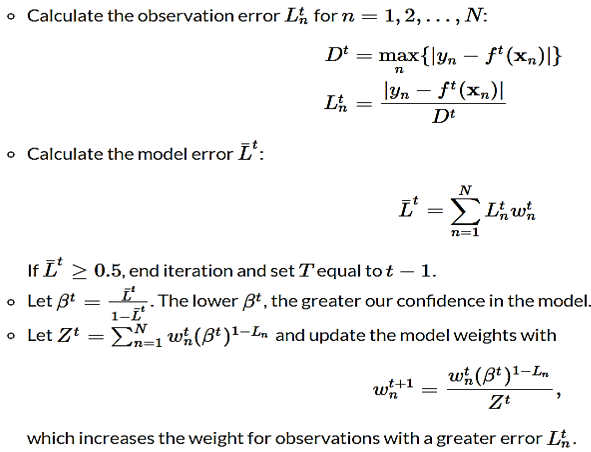

In [935]:
y_pred = dtr.predict(df.loc[:,cols]) #### ht
df['y_pred1'] = y_pred
df['err'] = np.abs(df['y'] - df['y_pred1'])
D1 = df['err'].max()
df['L1'] = df['err']/D1
Lbar1 = np.sum(df['L1']*df['w1'])
beta1 = Lbar1/(1-Lbar1)
Z1 = np.sum(df['w1']*(beta1**(1-df['L1'])))
print(D1, L1, beta1, Z1)

194.16730038022814 0.27944637948305856 0.38782176860422607 0.5140363447281372


In [936]:
df['w2'] = df['w1']*(beta1**(1-df['L1']))/Z1

In [937]:
df.iloc[:,8:].head(4)

,s5,s6,y,w1,y_pred1,err,L1,w2
0,0.032432,-0.005220,219.0,0.002262,116.832700,102.167300,0.526182,0.002810
1,-0.022517,-0.021788,70.0,0.002262,209.301676,139.301676,0.717431,0.003368
2,0.084492,-0.017646,202.0,0.002262,116.832700,85.167300,0.438628,0.002586
3,0.098648,0.061054,230.0,0.002262,209.301676,20.698324,0.106600,0.001888


#### Now let's build the loop to build many trees and aggregate the results

In [938]:
lbr = load_diabetes()
df = pd.DataFrame(lbr.data, columns=lbr.feature_names)
df['y'] = lbr.target
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

## Initialize the weight
w1 = 1/m
df['w1'] = w1

In [939]:
np.random.seed(seed=123)
model_weight = []
T=4
for i in range(T):
    dtr = DecisionTreeRegressor(random_state=42, max_depth=1)
    dfs = df.sample(n = m, replace = True, random_state=123, weights=df['w1'])
    dtr.fit(dfs.loc[:,cols], dfs['y'])
    
    y_pred = dtr.predict(df.loc[:,cols])
    df['y_pred'+str(i)] = y_pred
    df['err'] = np.abs(df['y'] - df['y_pred'+str(i)])
    D = df['err'].max()
    df['L'] = df['err']/D
    Lbar = np.sum(df['L']*df['w1'])
    if Lbar>=0.5:
        print('break')
        break
    beta = Lbar/(1-Lbar)
    
    model_weight.append(np.log(1/beta))
    
    Z = np.sum(df['w1']*(beta**(1-df['L'])))
    df['w2'] = df['w1']*(beta**(1-df['L']))/Z
    print(D, beta, Lbar, np.log(1/beta))
    df= df.drop('w1', axis=1)        
    df['w1'] = df['w2']

print(model_weight)
model_weight = np.asarray(model_weight)

197.02930402930403 0.38232266695632966 0.2765799014192162 0.9614903490190252
198.2801724137931 0.38478909499012337 0.2778683746010202 0.9550599000149109
215.1344827586207 0.40526712540691934 0.28839152220939296 0.903208860389598
173.72033898305085 0.6283308345980454 0.38587418554482467 0.4646884445430794
[0.9614903490190252, 0.9550599000149109, 0.903208860389598, 0.4646884445430794]


In [940]:
def weighted_median(values, weights):
    sorted_indices = values.argsort()
    values = values[sorted_indices]
    weights = weights[sorted_indices]
    weights_cumulative_sum = weights.cumsum()
    median_weight = np.argmax(weights_cumulative_sum >= sum(weights)/2)
    return values[median_weight]

In [941]:
cols = []
for j in range(T):
    cols.append('y_pred'+str(j))
dfs = df.loc[:,cols].values  

In [942]:
y_pred = ([weighted_median(dfs[n], model_weight) for n in range(m)]) 

In [943]:
print(r2_score(df['y'], y_pred))

0.3807107140409618


In [944]:
from sklearn.datasets import load_diabetes
lbr = load_diabetes()
df = pd.DataFrame(lbr.data, columns=lbr.feature_names)
df['y'] = lbr.target
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [945]:
cols = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [946]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
dtr = DecisionTreeRegressor(random_state=42, max_depth=1)
abr = AdaBoostRegressor(dtr, n_estimators=3)
abr.fit(df.loc[:,cols], df['y'])
y_pred = abr.predict(df.loc[:,cols])

print(r2_score(df['y'], y_pred))

0.3083236202403794


In [947]:
np.unique(y_pred) 

array([116.41287879, 127.22866894, 205.33777778, 206.1011236 ])